In [20]:
import sys

sys.path.append('..')

In [28]:
import geopandas as gpd

from modeling_lanternfly_populations.config import MODELS_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR

In [22]:
gdf = gpd.read_parquet(INTERIM_DATA_DIR / '0.5_deg_lanternfly.parquet')

array([[<Axes: title={'center': 'observation_count'}>]], dtype=object)

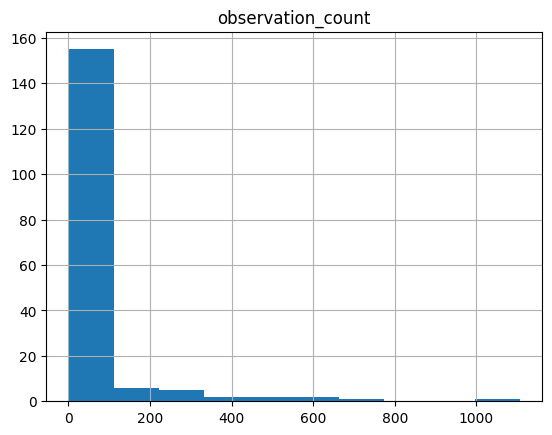

In [23]:
gdf.hist('observation_count')

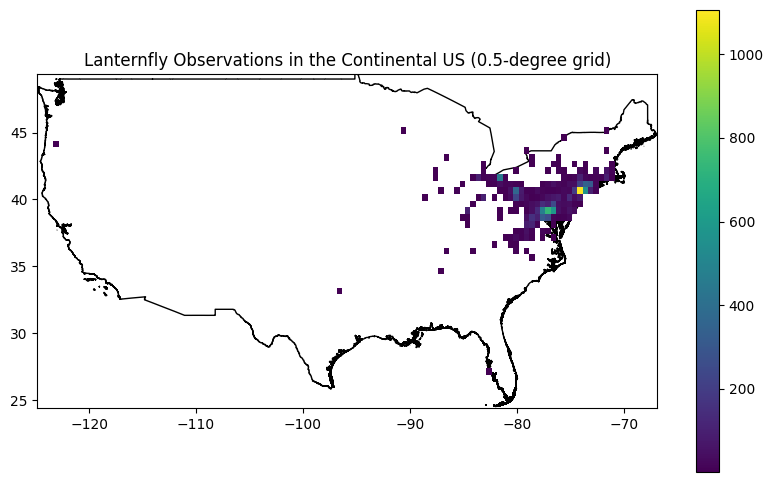

In [26]:
MIN_LON, MIN_LAT = -124.848974, 24.396308   # Southwest corner
MAX_LON, MAX_LAT = -66.885444, 49.384358    # Northeast corner
gadm_path = EXTERNAL_DATA_DIR / 'gadm41_USA_shp/gadm41_USA_0.shp'
# Read the GADM level-0 boundary
usa_admin = gpd.read_file(gadm_path)

# Make sure everything is in the same CRS, e.g., EPSG:4326
# (If your GADM is in a different CRS, reproject it)
if usa_admin.crs != 'EPSG:4326':
    usa_admin = usa_admin.to_crs('EPSG:4326')

if gdf.crs != 'EPSG:4326':
    gdf = gdf.to_crs('EPSG:4326')


try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot the grid, coloring by observation count
    usa_admin.plot(
    ax=ax,
    edgecolor='black',
    facecolor='none'
    )
    gdf.plot(
        column='observation_count',
        legend=True,
        figsize=(10, 6),
        ax=ax,
    )
    # gdf.plot(ax=ax, marker='o', markersize=5, alpha=0.5)
    plt.xlim(MIN_LON, MAX_LON)
    plt.ylim(MIN_LAT, MAX_LAT)
    plt.title("Lanternfly Observations in the Continental US (0.5-degree grid)")
    plt.show()

except ImportError:
    print("Install matplotlib to visualize results: pip install matplotlib")

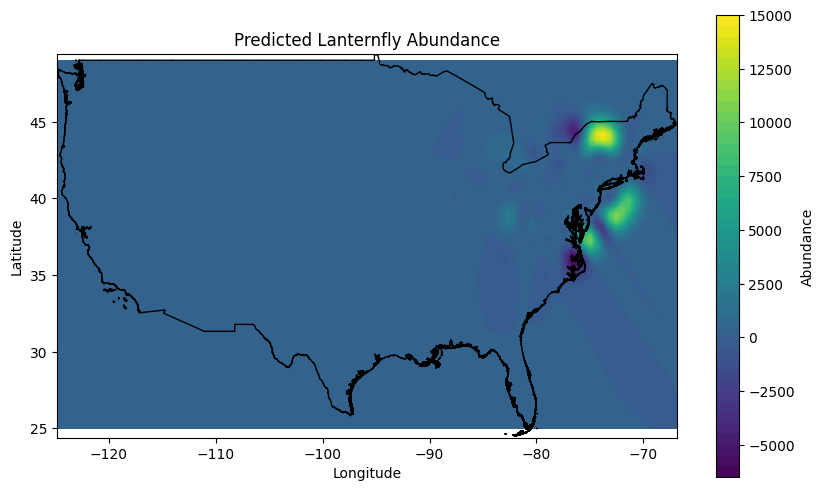

In [35]:
import numpy as np
import pickle

with open(MODELS_DIR / 'gp' / 'gp_model.pkl', 'rb') as file:
    gpr = pickle.load(file)

if usa_admin.crs != 'EPSG:4326':
    usa_admin = usa_admin.to_crs('EPSG:4326')

lon_vals = np.linspace(-125, -66, 100)  # Western to Eastern US
lat_vals = np.linspace(25, 49, 80)      # Southern to Northern US

grid_lon, grid_lat = np.meshgrid(lon_vals, lat_vals)
X_grid = np.column_stack([grid_lon.ravel(), grid_lat.ravel()])

# Predict on the grid
y_grid_pred, y_grid_std = gpr.predict(X_grid, return_std=True)


# Reshape for plotting (2D arrays)
y_grid_pred_2d = y_grid_pred.reshape(grid_lon.shape)

# At this stage, you could visualize using matplotlib:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))

contour = ax.contourf(lon_vals, lat_vals, y_grid_pred_2d, levels=50)
usa_admin.plot(
    ax=ax,
    edgecolor='black',
    facecolor='none'
    )
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Predicted Lanternfly Abundance')
cbar = fig.colorbar(contour, ax=ax, label='Abundance')
ax.set_xlim(MIN_LON, MAX_LON)
ax.set_ylim(MIN_LAT, MAX_LAT)
plt.show()